In [700]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Introduction
TikTok is a wildly popular video sharing platform. While I am not a TikTok user, I am still interested in the platform. So when I came accross some data listing the 1000 most popular TikTok users, I was interested in how the users had been ranked. To narrow the issue, I decided to ask whether the user rank was a linear combination of features provided, specifically a number of subscribers and various average engagement metric. I leaned toward no. Too much information was left out that could plausibly be useful for ranking a user. Were their subscribers increasing or decreasing? Where were their videos shared? How many unique average comments did they get, to prevent counting potential bot comments? If a user gets 10M views average, do we treat a user with 10 or 100 videos differently? None of this was accounted for in the data. 


Still, the only way to learn if the ranking was a linear combination of features given was to train a model, and that is what I do in this notebook.

# Load Data
The data was obtained from Kaggle, [here](https://www.kaggle.com/datasets/syedjaferk/top-1000-tiktokers).

In [701]:
df = pd.read_csv('top_1000_tiktokers.csv')
df.head()

,Rank,Username,Tiktok Link,Name,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,badbunny,https://www.tiktok.com/@badbunny,Bad Bunny,23.4M,63.1M,10.3M,65.2K,108.6K
1,2,noahschnapp,https://www.tiktok.com/@noahschnapp,Noah Schnapp,26.1M,23.4M,4.8M,46.7K,22.1K
2,3,khaby.lame,https://www.tiktok.com/@khaby.lame,Khabane lame,145.9M,47.5M,2.5M,46K,9.4K
3,4,coopernoriega,https://www.tiktok.com/@coopernoriega,Cooper Noriega,3.2M,31M,1.3M,120.9K,8.4K
4,5,avrillavigne,https://www.tiktok.com/@avrillavigne,Avril Lavigne,4M,24.7M,3.5M,32.1K,22.7K


In [702]:
df.drop(['Username', 'Tiktok Link', 'Name'], axis=1, inplace=True)
df.head()

,Rank,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,23.4M,63.1M,10.3M,65.2K,108.6K
1,2,26.1M,23.4M,4.8M,46.7K,22.1K
2,3,145.9M,47.5M,2.5M,46K,9.4K
3,4,3.2M,31M,1.3M,120.9K,8.4K
4,5,4M,24.7M,3.5M,32.1K,22.7K


## Fix Data Types
Most of the features look like they are strings. They should be floats. I correct that below.

In [703]:
df.dtypes

Rank                  int64
Subscribers Count    object
Views. Avg           object
Likes. Avg           object
Comments. Avg        object
Shares. Avg          object
dtype: object

To convert the strings to floats, I have to check for the character suffix, then multiply the number in the string accordingly. I assume M is million and K is thousand. Probably the values end only either in those letters or no letter at all, but I check for completeness.

In [704]:
# non-target features
x_cols = df.columns[1:]

for col in x_cols:
    col_suffixes = list(set([suffix for suffix in df[col].str[-1] if suffix.isalpha()]))
    print(f'Unique suffixes for {col}: {col_suffixes}')

Unique suffixes for Subscribers Count: ['M', 'K']
Unique suffixes for Views. Avg: ['M', 'K']
Unique suffixes for Likes. Avg: ['M', 'K']
Unique suffixes for Comments. Avg: ['K']
Unique suffixes for Shares. Avg: ['K']


As expected, the numbers either end in M, K, or possible nothing.

In [705]:
def str_to_float(str_num):
    '''
    Converts strings in the form 123.4K, 123.4M or 123.4 to floats.
    '''
    if type(str_num) == str:
        if str_num[-1] == 'M':
            return float(str_num[:-1]) * 1_000_000
        elif  str_num[-1] == 'K':
            return float(str_num[:-1]) *1_000
        else:
            return float(str_num)
    else:
        return str_num

thousand_ex = '10.3K'
mill_ex = '324.5M'
hund_ex = '123'

print('The str_to_float function works as follows')
print(f'{thousand_ex} becomes {str_to_float(thousand_ex)}')
print(f'{mill_ex} becomes {str_to_float(mill_ex)}')
print(f'{hund_ex} becomes {str_to_float(hund_ex)}')

The str_to_float function works as follows
10.3K becomes 10300.0
324.5M becomes 324500000.0
123 becomes 123.0


Next I apply this function to the string columns of the dataframe and check the results.

In [706]:
# Convert strings to floats
for col in df.columns[1:]:
    df[col] = df[col].map(lambda x: str_to_float(x))

df.head()

,Rank,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
0,1,23400000.0,63100000.0,10300000.0,65200.0,108600.0
1,2,26100000.0,23400000.0,4800000.0,46700.0,22100.0
2,3,145900000.0,47500000.0,2500000.0,46000.0,9400.0
3,4,3200000.0,31000000.0,1300000.0,120900.0,8400.0
4,5,4000000.0,24700000.0,3500000.0,32100.0,22700.0


# Exploratory Data Analysis

In [707]:
df[x_cols].describe()

,Subscribers Count,Views. Avg,Likes. Avg,Comments. Avg,Shares. Avg
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,6.906116e+06,3.330490e+06,3.995059e+05,3464.326000,3649.304000
std,1.139041e+07,3.514470e+06,4.632153e+05,6389.809003,6019.052223
min,3.700000e+03,6.679000e+05,4.570000e+04,0.000000,95.000000
25%,1.300000e+06,1.800000e+06,2.232500e+05,1200.000000,928.500000
50%,3.500000e+06,2.600000e+06,3.049000e+05,2000.000000,1900.000000
75%,7.925000e+06,3.700000e+06,4.372250e+05,3400.000000,3900.000000
max,1.459000e+08,6.310000e+07,1.030000e+07,120900.000000,108600.000000


Even before visual examinations, the means of all of these features have very high standard deviations relative to their respective means. The range between minimum and maximum values is often very large, up to several orders of magnitude. And maximum values are at least an order of magnitude larger than the third quartile in all of the distributions.

## Univariate Analysis

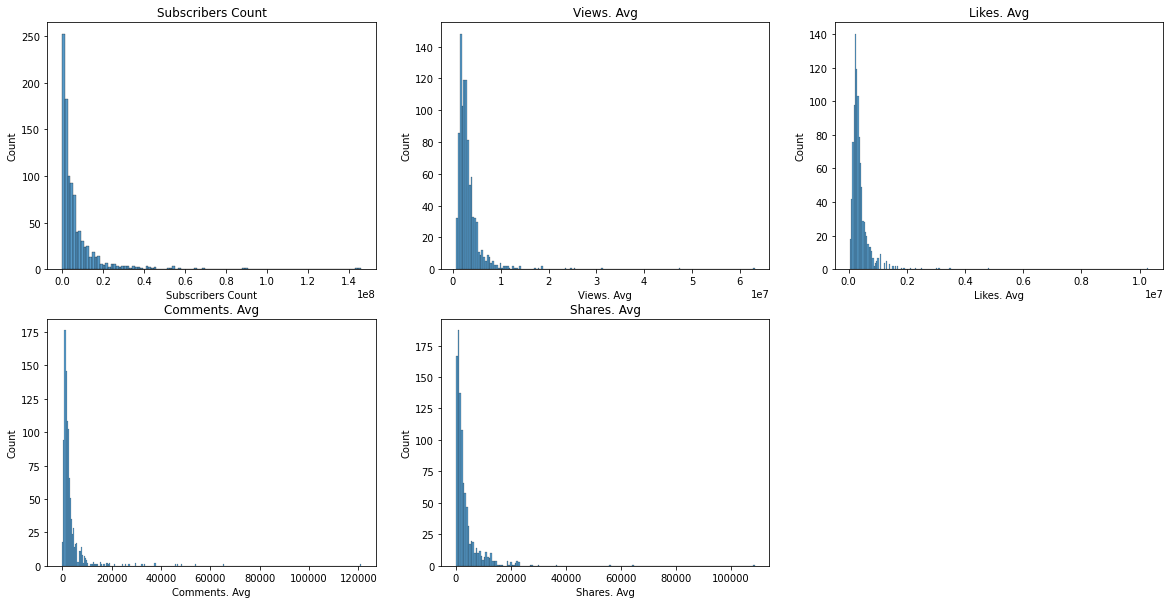

In [708]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
for col, ax in zip(x_cols, np.ravel(axes)):
    sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(col)

axes[-1,-1].axis('off')
plt.show()

We see here that the distributions are all very right skewed, i.e. their medians are less than their means, with very long tails. However, this is expected, and we do not want to throw away any values as outliers. Typically, on social media apps like Tik Tok, a very small minority of users will far, far outperform even just moderately less popular users with respect to engagement metrics, and it appears that this is what we see here.

## Bivariate Analysis
Relationships between variables should be expected. Whether these relationships are linear is another question. Regarding the target variable, it only makes sense that rank would increase with an increase in subscribers, average views, etc. One would also expect, for example, likes, shares, and comments to go up with views. But when building linear models, a key question is whether one feature can be predicted from specifically a linear combination of others.

To check relationships between variables, I first look at correlation coefficients, then I plot the variables against one another.

<AxesSubplot:>

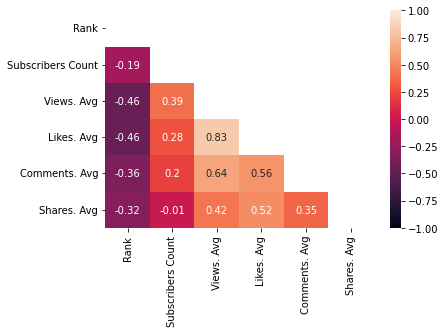

In [709]:
corr = df.corr()
mask = np.triu(corr)

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask)

As expected, rank negatively correlates with all of the variables, although the strength of the correlation varies. There are also correlations between most variables. Interestingly,  subscriber counts and average shares have nothing to do with each other. Average views and average likes, however, are very strongly correlatd.

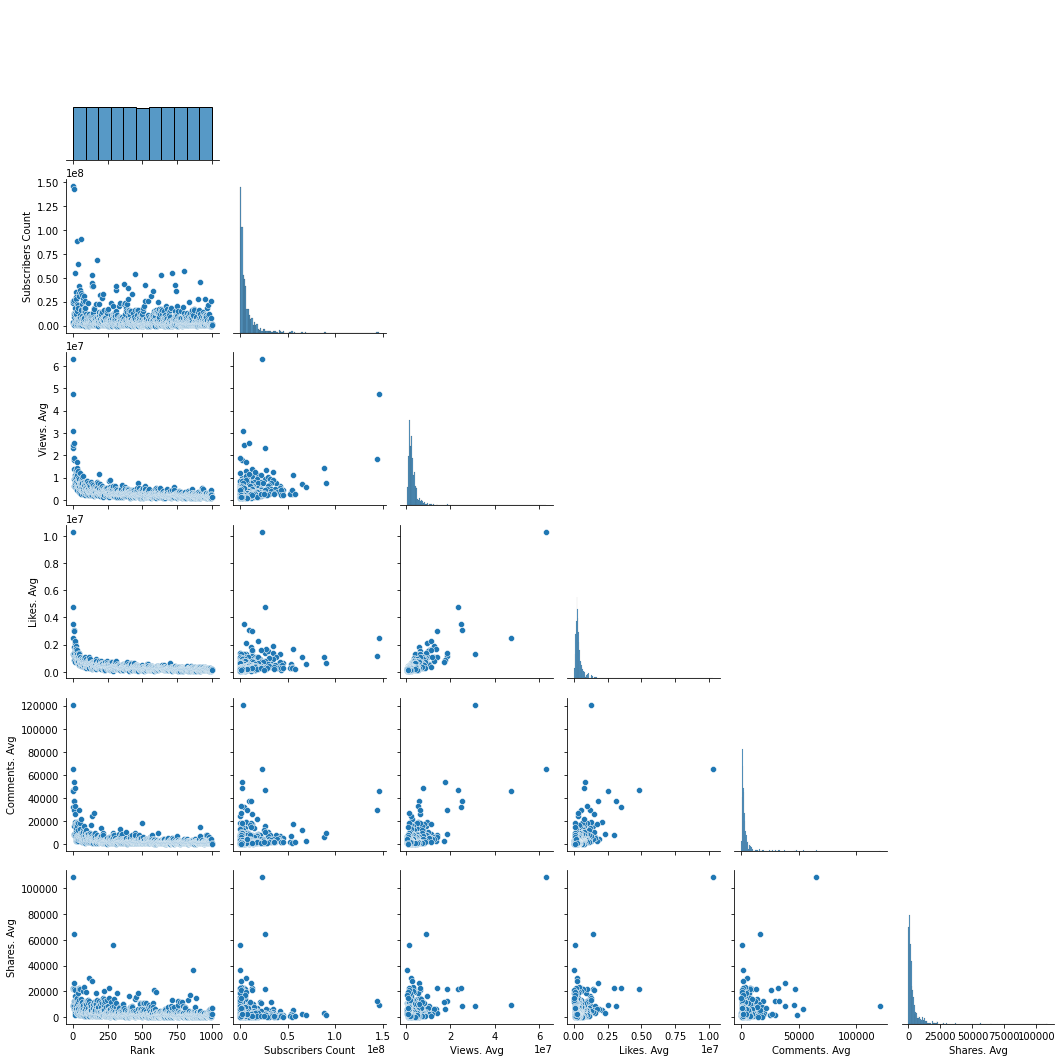

In [710]:
sns.pairplot(df, corner=True)

From the above, it looks like the relationship between rank and the predictor variables other than the number of subscribers could be made more linear by taking a log transform of the features. This transformation is performed below.

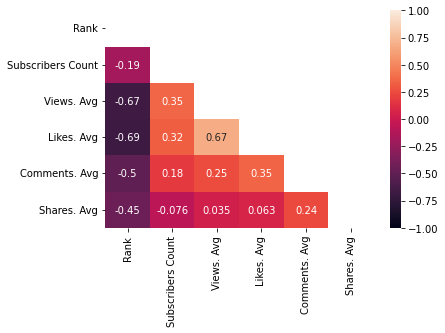

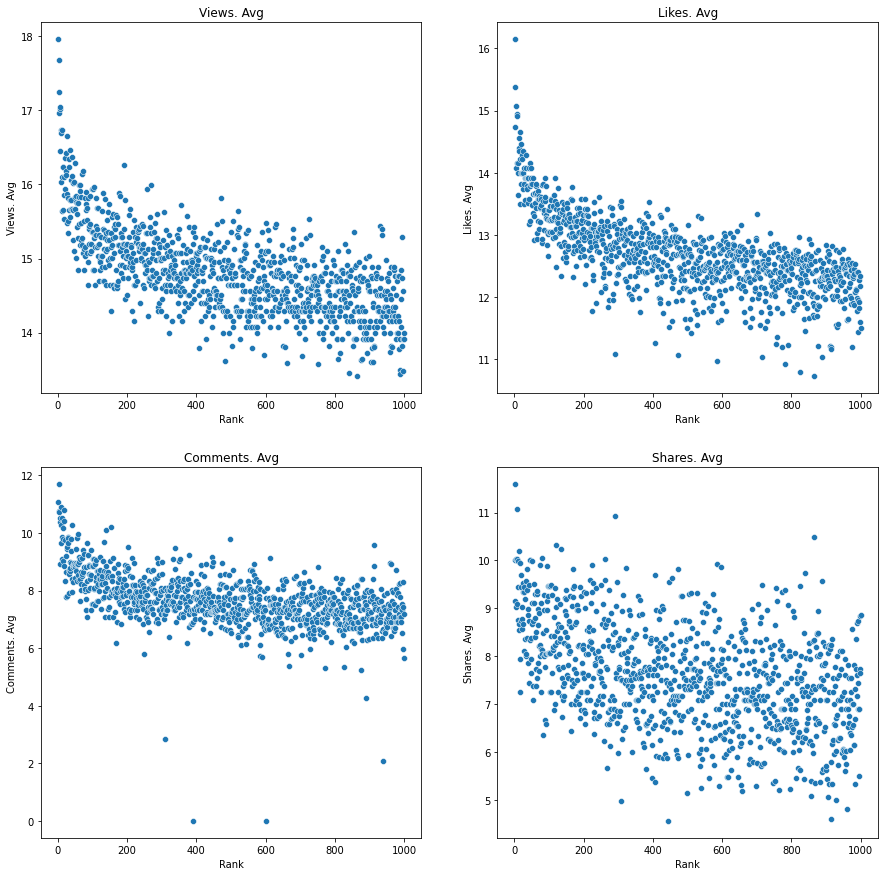

In [711]:
# Take log transform of non-target variables except subscribers
df_semi_log = df.copy()
df_semi_log[df_semi_log.columns[2:]] = np.log(df_semi_log[df_semi_log.columns[2:]]+1)

corr = df_semi_log.corr()
mask = np.triu(corr)

# Plot the correlations again
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, mask=mask)
plt.show()

# Plot some bivariate plots with the transformed data
fig, axes = plt.subplots(2,2, figsize=(15,15))

for col, ax in zip(df_semi_log[df_semi_log.columns[2:]], np.ravel(axes)):
    sns.scatterplot(data=df_semi_log, x='Rank', y=col, ax=ax)
    ax.set_title(col)

We can see from the above that the negative correlations between the transformed features and Rank are now stronger. Further, from the plots, it looks like the relationships are much more linear, particularly in the case of Shares. Avg. Additionally, the transformation  reduced some of the stronger correlations between predictors, although it also increased some of the weaker ones.

For the sake of interpretability, I rely on the data that has not been log-transformed to do clustering analysis below, but the log-transformed data will be used to build a linear regression model.

## Clustering
There may be interesting information in the data that only becomes apparent when clustered. For example, perhaps a cluster of users has high average shares but low subscribers or a cluster has fewer likes on average but more comments.

To cluster the data, I use k-means clustering. In k-means clustering, a centroids for clusters are chosen with the objective of minimizing the sum of distances between points in a cluster and the cluster's centroid. First some fixed number of clusters k is chosen. Second, k points are chosen to be cluster centroids. Third, points are assigned to their nearest centroid. Fourth, centroids are recomputed to be the center of each cluster. The third and fourth steps are then repeated until some maximum number of iterations has passed.

### Transforming Data for Clustering
At a basic level, k-means clustering cares about the distance between points. For this reason, each factor is scaled so it has mean of zero and standard deviation of 1. 

Additionally, while not required by k-means, I transform the data to become more normal using a Box Cox transformation. This will be useful for visualizations. For a feature $y$, the Box Cox transformation finds the value $\lambda$ that makes $y$ best approximate the normal distribution after the following transformation:

$\displaystyle y(\lambda)  =  \frac {{y}^{ \lambda} - 1}{\lambda} $ when $\lambda \neq 0$

 $y(\lambda) = log(y)$ when $\lambda = 0$

Since the Box Cox transformation tries a log transformation, and the data contains zero values, I add 1 to the data before transforming it.

Transforming Subscribers Count with lambda = 0.17466759525241948
Transforming Views. Avg with lambda = -0.3552276470926497
Transforming Likes. Avg with lambda = -0.18576848974199864
Transforming Comments. Avg with lambda = 0.07319704734975091
Transforming Shares. Avg with lambda = -0.04638530260865479
Below are histograms of the transformed features


C:\Users\Patrick\AppData\Local\Temp/ipykernel_11728/95720062.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_boxcox.hist(ax=ax)


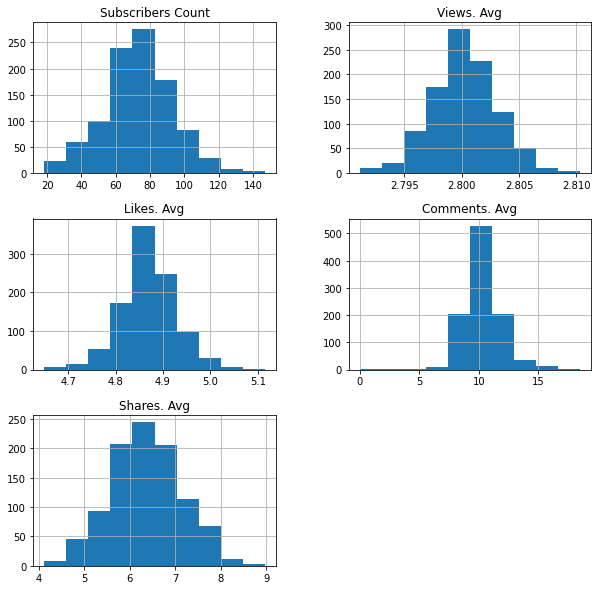

In [712]:
def df_boxcox_transform(df):
    df_vals = np.zeros(df.shape)
    for i, col in enumerate(df.columns):
        # Add a constant to avoid log(0)
        values, l = stats.boxcox(df[col]+1)
        print(f'Transforming {col} with lambda = {l}')
        df_vals[:, i] = values
    df_transformed = pd.DataFrame(df_vals, columns=df.columns)
    return df_transformed

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
df_boxcox = df_boxcox_transform(df[x_cols])
df_boxcox.hist(ax=ax)
print('Below are histograms of the transformed features')

plt.show()

We can visually confirm that the features look at least much more normal than before. Additionally, we can see what kind of transformation was performed on each feature.

### Selecting k
As stated above, k-means requires a pre-selected value for k. The value for k is chosen here using the "elbow method." Clustering is performed for a range of k values between 1 and 20. For each value of k, the sum of squared distances of samples to the closest cluster centroid is plotted. The expectation is that this quantity should first decrease quickly as k decreases then begin to decrease more slowly. The number k chosen when the decrease begins to slow down. The goal of k-means begin to decrease the sum of squared distances from samples to cluster centroids but also wanting to have useful clusters, k is chosen at a point when the benefit of adding a new cluster begins to decrease substantially. On the ideal plot, k would look like an elbow before a plateau.

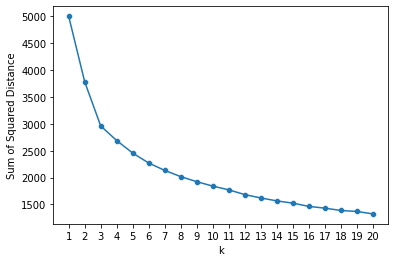

In [713]:
ss = StandardScaler()

# Scale so mean=0 std=1
scaled_values = ss.fit_transform(df_boxcox)

k_range = range(1, 21)

sse = []
for k in k_range:
    kmeans = KMeans(k, random_state=123)
    kmeans.fit(scaled_values)

    sse.append(kmeans.inertia_)

sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)
plt.ylabel('Sum of Squared Distance')
plt.xlabel('k')
plt.xticks(k_range)
plt.show()

I chioose k=3. Note how from k=1 to k=2, the sum of squared distances decreases substantially, as it does from k=2 to k=3. But after that, the decrease begins to slow down greatly. This is how we know that k=3 is the "elbow."

### Finding and Examining CLusters
Here clusters are found using the value k=3 selected above. After computing the clusters, the mean and standard deviation for each feature and each cluster are presented and discussed.

In [714]:
kmeans = KMeans(3, random_state=123)
kmeans.fit(scaled_values)

df_scaled = pd.DataFrame(scaled_values, columns=x_cols)
df_scaled['cluster assignment'] = kmeans.labels_

In [715]:
df['cluster assignments'] = kmeans.labels_
agg_cluster_stats = df.groupby('cluster assignments').agg(['mean', 'std', 'count']).round(2)
df.drop('cluster assignments', axis=1, inplace=True)
agg_cluster_stats

Rank               Subscribers Count               \
                       mean     std count              mean          std   
cluster assignments                                                        
0                    623.76  241.05   315        1875060.32   2312054.39   
1                    590.92  223.18   475        7869168.63   8723429.28   
2                    111.10   68.00   210       12274364.76  19243736.39   

                           Views. Avg                   Likes. Avg             \
                    count        mean         std count       mean        std   
cluster assignments                                                             
0                     315  1785691.75   731533.76   315  218053.02   90206.61   
1                     475  2957045.68  1172214.18   475  329619.16  121658.71   
2                     210  6492380.95  6415571.60   210  829762.38  856208.53   

                          Comments. Avg                 Shares. Avg           \
                    count          mean       std count        mean      std   
cluster assignments                                                            
0                     315       2411.35   1850.78   315     5416.90  5707.20   
1                     475       1926.43   1598.70   475     1143.57   850.92   
2                     210       8522.38  12307.17   210     6665.64  9719.68   

                           
                    count  
cluster assignments        
0                     315  
1                     475  
2                     210

While the mean and standard deviation are discussed below, first note the cluster membership. While the cluster membership is not completely balanced, each cluster contains a decent number of samples, which is a good initial sanity check suggesting the clustering did not at least go horribly wrong.

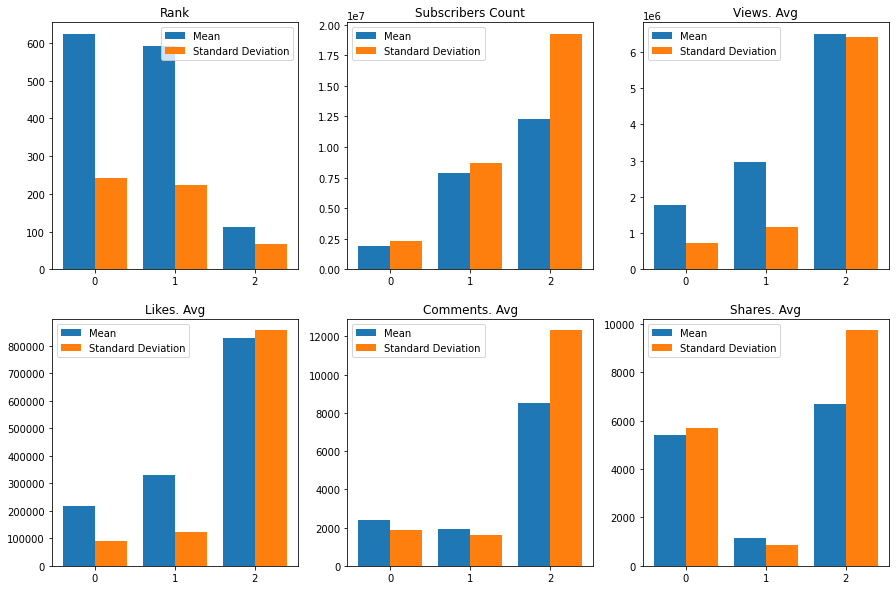

In [716]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for col, ax in zip(df.columns, np.ravel(axes)):
    x_ix = np.arange(agg_cluster_stats[col]['std'].shape[0])
    ax.bar(x=x_ix-0.2, height=agg_cluster_stats[col]['mean'].values, width=0.4, label='Mean')
    ax.bar(x=x_ix+0.2, height=agg_cluster_stats[col]['std'].values, width=0.4, label='Standard Deviation')
    ax.set_xticks(ticks=x_ix)
    ax.set_title(col)
    ax.legend()

From the above, the clusters can be described as followed:
* The 0th cluster has a fairly low mean rank. Relative to the other clusters, it consists of users with the fewest subcribers and low mean numbers of views, likes, and comments. HOwever, it has a relatively high mean number of shares, albeit with a high standard deviation on the distribution of shares.
* The 1st cluster has a similar mean rank to the 0th. However, it has a much lower mean number of average sharwes and higher subscriber counts and mean views. The mean number of average comments is similar to the 0th cluster.
* The 2nd cluster has the lowest mean rank and an accompanying low standard deviation, meaning it consists of higher ranked users. It has high values for subscriber counts and mean number of average views, likes, comments and shares. However, all of these values have very high associated standard deviation.

How this could potentially be interpreted is that among the lower ranked users in the top 1000 Tik Tok users, there are those that rely more on shares and those that rely more on consistent subscribers.

## Cluster Visualization
The clusters will be visualized using principal component analysis. Principal component analysis (PCA) is a dimension reduction technique. Specifically, PCA finds a number of orthogonal vectors called principal components. Each principal component explains some portion of the variability of the dataset, and all of the principal components explain all of the variance. The first principal components will explain the largest portion of the variance, the second a bit less, the third even less and so on. For visualizing clusters, typically the first two principal components are used, as they should produce show the most separability between clusters. Note that PCA assumes featurse are normally distributed with mean 0 and standard deviation of 1, but transformations to achieve these distributions were performed above.

The big downside of PCA is a loss of interpretability. The conceptual explanation of each principal component is just the direction that explains a certain amount of variance or a certain portion of total variance. That does not relate back to the original features. So while PCA can provide visual proof that clusters are separate, it provides little additional information about the clusters themselves.

In [717]:
# Perform PCA
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=[f'pc_{i+1}' for i in range(df_scaled.shape[1])])
df_pca['cluster assignment'] = kmeans.labels_
df_pca.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,cluster assignment
0,6.564392,4.122539,-0.123903,0.604673,-0.311689,1.484061,2
1,5.720040,2.883934,-0.580752,0.174808,-0.274617,1.142076,2
2,6.384972,1.520812,-1.706691,0.962108,0.661988,1.442491,2
3,4.806829,3.511920,-0.734113,-1.935310,1.088440,0.904625,2
4,4.789878,3.228347,0.561380,-0.487372,-0.151255,0.835909,2


With the principal components shown, we can now check what portion of the variance each component explains.

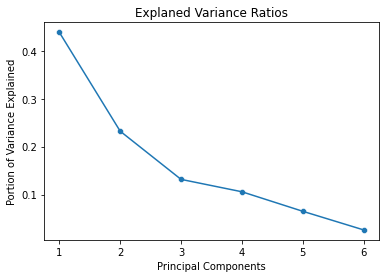

In [718]:
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_)
sns.scatterplot(x=range(1, len(pca.explained_variance_ratio_)+1), y=pca.explained_variance_ratio_)
plt.title('Explaned Variance Ratios')
plt.ylabel('Portion of Variance Explained')
plt.xlabel('Principal Components')
plt.show()

While not an ideally shaped graph, this is about what to expect. Note how the first principal component explains a great deal more of the variance than the second, and the second explains relatively less than the third and so on. This is what is expected.

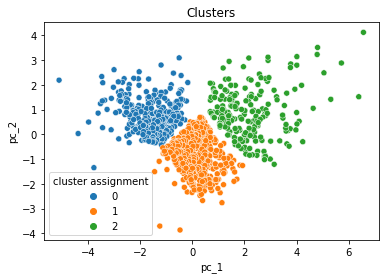

In [719]:
sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue='cluster assignment', palette='tab10')
plt.title('Clusters')
plt.show()

Above we can see that the clusters are very nicely separated when the data is projected onto the principal components.

# Model Training

In [720]:
X = df[df.columns[1:]]
y = df['Rank']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_log = df_semi_log[df_semi_log.columns[1:]]
y = df_semi_log['Rank']
x_train_log, x_test_log, y_train_log, y_test_log= train_test_split(X_log, y, test_size=0.2, random_state=123)

## Feature Scaling
In order to train the regression model, the features need to be scaled into the same range. To do this, the features are scaled such that they have mean 0 and standard deviation 1.

In [721]:
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

ss_log = StandardScaler()
x_train_log_scaled = ss_log.fit_transform(x_train_log)
x_test_log_scaled = ss_log.transform(x_test_log)

# Training and Evaluation
The models are trained on the scaled data.

In [722]:
def train(x_train, y_train, x_test, y_test):
    # Define and fit model
    lr = LinearRegression()
    lr.fit(x_train, y_train)

    # Evaluate model
    train_score = lr.score(x_train, y_train)
    test_score = lr.score(x_test, y_test)
    print(f'The R2 on the training set is {train_score}')
    print(f'The R2 on the test set is {test_score}')
    return lr

In [723]:
print('Untransformed data results:')
lr = train(x_train_scaled, y_train, x_test_scaled, y_test)

print('\nLog-transformed data results:')
lr_log = train(x_train_log_scaled, y_train_log, x_test_log_scaled, y_test_log)

Untransformed data results:
The R2 on the training set is 0.23301452657144017
The R2 on the test set is 0.2949700894185199

Log-transformed data results:
The R2 on the training set is 0.7550584007429915
The R2 on the test set is 0.7374432183169696


We can see that the model performs fairly well, but only when we log-transform some of the data. In that case, the model gets an R2 of 0.73, meaning that the model explains 73% of the variability in the data. Given the model performs so much better when trained on transformed data, I only use the model trained on transformed data for further analysis.

### Evaluation
First predictions are plotted against ground truth values. If the model predicted every value correctly, this would be a straight line with slope 1.

Next, residuals (the difference between ground truth and predicted values) are plotted against ground truth values. Linear regression assumes normally distributed residuals, and the ideal plot would have the residual values normally distributed about a horizontal line at y=0.

Text(0.5, 0, 'Ground Truth')

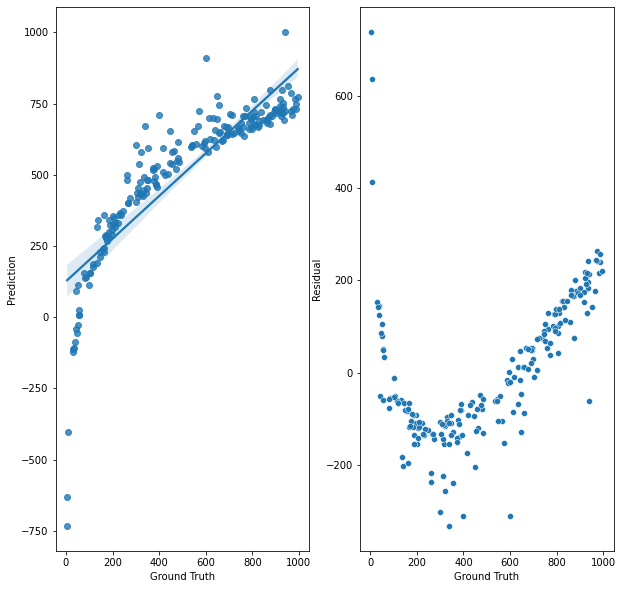

In [724]:
y_pred = lr_log.predict(x_test_log_scaled)
residuals = y_test_log.values - y_pred

fig, axes = plt.subplots(1, 2, figsize=(10,10))

sns.regplot(x=y_test_log, y=y_pred, ax=axes[0])
axes[0].set_ylabel('Prediction')
axes[0].set_xlabel('Ground Truth')
axes[0].set_title('Prediction vs. Ground Truth')


sns.scatterplot(x=y_test_log, y=residuals, ax=axes[1])
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Ground Truth')
axes[1].set_title('Residuals vs. Ground Truth')


We can see from the above that neither plot looks as expected. The plot of predictions against the ground truth has a curve which is particularly pronounced for lower ground truth Rank values. And the residual plot has a U-shaped curve. The fact that there seems to be a distinct curve on the residual plot means there is a nonlinear relationship between the predictor variables and the target variable. Many of residuals are also quite large, meaning that the predictions are quite far off.

It is possible that introducing nonlinear transformations of predictors addresses these issues.

## Feature Engineering and Re-Training

In [725]:
df_sq = df_semi_log.copy()
# Take reciprocal, square, and asinh of features
for col in df_semi_log.columns[1:]:
     df_sq[f'{col} reciprocal'] = np.log(df_semi_log[col]+1)
     df_sq[f'{col} squared'] = df_semi_log[col]**2
     df_sq[f'{col} asinh'] = np.arcsinh(1/(df_semi_log[col]+1))

In [726]:
# Data is split into train and test sets again

X = df_sq[df_sq.columns[1:]]

y = df_sq['Rank']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Data is scaled again
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

print('Training results with squared features added:')
lr = train(x_train_scaled, y_train, x_test_scaled, y_test)

Training results with squared features added:
The R2 on the training set is 0.8988889812591236
The R2 on the test set is 0.8407337355153994


The R2 has increased - although so has the gap between performance on the training and test sets, probably due to increased model complexity - but we still need to check if the residuals are normally distributed before being satisfied with the model.

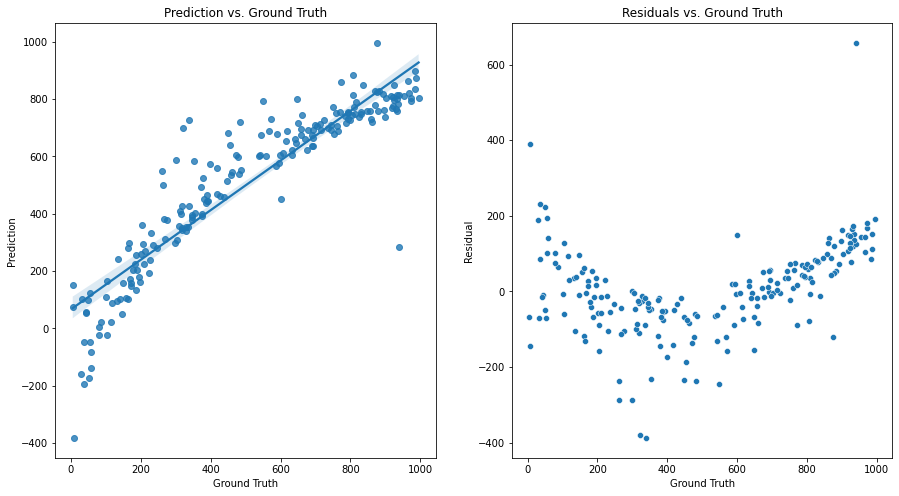

In [727]:
y_pred = lr.predict(x_test_scaled)
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.regplot(x=y_test, y=y_pred, ax=axes[0])
axes[0].set_ylabel('Prediction')
axes[0].set_xlabel('Ground Truth')
axes[0].set_title('Prediction vs. Ground Truth')

sns.scatterplot(x=y_test, y=residuals, ax=axes[1])
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Ground Truth')
axes[1].set_title('Residuals vs. Ground Truth')
plt.show()

We can see from the above that after adding a good deal of non-linear transformations of the features, the u-shaped pattern in the residual plot is perhaps a bit less obvious but is still very much present. Additionally, the residuals are still very large. For this reason, there is still some non-linear relationship in the data.

# Conclusion
The rank is not a linear combination of the features in the data.